# FB Prophet Model

In this Jupyter Notebook I will be fitting the Facebook Prophet Model. I will be including the dew point column on the first fitting and reconsider dropping the column after reviewing the results.

In [1]:
# First we wil import the necessary packages for this notebook.
import numpy as np
import pandas as pd
import calendar

# Stats imports
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import matplotlib.pyplot as plt

# Google Colab imports.
from google.colab import drive
import io


In [2]:
# Mounting my google drive to have easy access to the dataset.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Uploaded dataset from Google Drive.
file_path = '/content/drive/MyDrive/weatherstats_vancouver_hourly_clean.csv'
df = pd.read_csv(file_path)
df.head()

,date_time_local,pressure_station,pressure_sea,wind_dir,wind_speed,wind_gust,relative_humidity,dew_point,temperature,windchill,humidex,visibility,health_index,cloud_okta,max_air_temp_pst1hr,min_air_temp_pst1hr
0,2013-07-01 00:00:00,101.18,101.16,SSE,7,0.0,91,18.2,19.7,0.0,0.0,32200.0,2.9,5.0,19.4,18.5
1,2013-07-01 01:00:00,101.22,101.21,SE,6,0.0,89,17.8,19.6,0.0,0.0,32200.0,3.0,5.0,20.1,18.7
2,2013-07-01 02:00:00,101.26,101.24,E,11,0.0,88,16.7,18.7,0.0,0.0,32200.0,3.0,5.0,19.8,18.0
3,2013-07-01 03:00:00,101.26,101.25,E,4,0.0,84,16.5,19.2,0.0,0.0,32200.0,2.7,5.0,18.5,17.5
4,2013-07-01 04:00:00,101.30,101.28,NNW,5,0.0,87,15.7,17.9,0.0,0.0,32200.0,2.6,5.0,18.8,17.3


In [4]:
# Setting the Date column to data type "Datetime"
df['date_time_local'] = pd.to_datetime(df['date_time_local'], utc=False)

In [5]:
# Running the .info to confirm date_time_local is set as datetime data type.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87648 entries, 0 to 87647
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_time_local      87648 non-null  datetime64[ns]
 1   pressure_station     87648 non-null  float64       
 2   pressure_sea         87648 non-null  float64       
 3   wind_dir             87648 non-null  object        
 4   wind_speed           87648 non-null  int64         
 5   wind_gust            87648 non-null  float64       
 6   relative_humidity    87648 non-null  int64         
 7   dew_point            87648 non-null  float64       
 8   temperature          87648 non-null  float64       
 9   windchill            87648 non-null  float64       
 10  humidex              87648 non-null  float64       
 11  visibility           87648 non-null  float64       
 12  health_index         87648 non-null  float64       
 13  cloud_okta           87648 non-

## Model #4

In [6]:
# As previously established in the EDA portion, these four columns will be dropped.
data = df.drop(['max_air_temp_pst1hr', 'min_air_temp_pst1hr', 'pressure_sea', 'wind_dir'], axis=1)

In [7]:
# Prophet needs a ds column with datetime type data and a y column for the dependent variable.
data_for_prophet = data.rename(columns={"date_time_local": "ds", "temperature": "y"})

In [8]:
# The data will be split before and after June 30, 2020 using the "ds" column from above for it.
train_data = data_for_prophet[data_for_prophet['ds'] <= '2020-06-30']
test_data = data_for_prophet[data_for_prophet['ds']>"2020-06-30"]

In [9]:
# Printing the shape of the data to check the split was succesful.
print(f" train_data Shape is: {train_data.shape}")
print(f" test_data Shape is: {test_data.shape}")

 train_data Shape is: (61345, 12)
 test_data Shape is: (26303, 12)


In [10]:
# This is the 4th model being considered in this project.
model_4 = Prophet()

In [11]:
# Here I initiate a for loop to go over the columns and add a regressor for each. This allows for multivariate handling in the prophet model.
for column in ['pressure_station', 'wind_speed', 'wind_gust', 'relative_humidity', 'dew_point', 'windchill', 'humidex', 'visibility', 'health_index', 'cloud_okta']:
    model_4.add_regressor(column)

# Fitting the model with the training data
model_4.fit(train_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp97p1nxzt/oistyfyj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp97p1nxzt/7b6rhjvq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92590', 'data', 'file=/tmp/tmp97p1nxzt/oistyfyj.json', 'init=/tmp/tmp97p1nxzt/7b6rhjvq.json', 'output', 'file=/tmp/tmp97p1nxzt/prophet_modelds5koca5/prophet_model-20230830212455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:24:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:25:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [12]:
# Creating a dataframe for the predictions using only the ds column (dates), this includes the whole time frame of the data set.
future = pd.concat([train_data[['ds']], test_data[['ds']]], ignore_index=True)

# Adding the additional regressor values from both training and test data to the future dataframe.
for column in ['pressure_station', 'wind_speed', 'wind_gust', 'relative_humidity', 'dew_point', 'windchill', 'humidex', 'visibility', 'health_index', 'cloud_okta']:
    future[column] = data_for_prophet[column]

# Model #4 is now use to predict values over the whole time frame of the data set.
forecast = model_4.predict(future)

In [13]:
# This function is to define the mape, which will be used to evaluate the models.
def mean_absolute_percentage_error(true_values, predicted_values):
    """
    Calculate the mean absolute percentage error.
    Find the prediction error and devide by the true value, then average.
    """
    # Filter out the zero values to avoid division by zero
    mask = true_values != 0
    true_values = true_values[mask]
    predicted_values = predicted_values[mask]

    error = true_values - predicted_values
    absolute_percentage_error = np.abs(error/true_values)
    mape = absolute_percentage_error.mean() * 100

    return mape

In [14]:
# The predictions stored in "forecast" were made on the train and test data and needs to be split again.
forecast_train = forecast.loc[forecast['ds'] <= "2020-06-30"]
forecast_test = forecast.loc[forecast['ds'] > "2020-06-30"]

# Extracting the predicted and true values for the training data. The 'yhat' column was created by the prophet model in the .predict() stage, it includes the predictions.
y_train_pred = forecast_train['yhat']
y_train_true = train_data['y']

# Computing the metrics for training data
train_mae = mean_absolute_error(y_train_true, y_train_pred)
train_mse = mean_squared_error(y_train_true, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mape = mean_absolute_percentage_error(y_train_true, y_train_pred)
train_r2 = r2_score(y_train_true, y_train_pred)

print(f'''Training Data:
Mean Absolute Error: {round(train_mae, 4)}
Mean Squared Error: {round(train_mse, 4)}
Root Mean Squared Error: {round(train_rmse, 4)}
Mean Absolute Percentage Error: {round(train_mape, 2)}%
R-squared: {train_r2}''')

# Extracting the predicted and true values for the test data
y_pred = forecast_test['yhat']
y_true = test_data['y']

# Computing the metris for the test data
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'''Test Data:
Mean Absolute Error: {round(mae, 4)}
Mean Squared Error: {round(mse, 4)}
Root Mean Squared Error: {round(rmse, 4)}
Mean Absolute Percentage Error: {round(mape, 2)}%
R-squared: {r2}''')

Training Data:
Mean Absolute Error: 0.2203
Mean Squared Error: 0.1151
Root Mean Squared Error: 0.3393
Mean Absolute Percentage Error: 6.46%
R-squared: 0.9970731589220392
Test Data:
Mean Absolute Error: 0.3193
Mean Squared Error: 0.201
Root Mean Squared Error: 0.4484
Mean Absolute Percentage Error: 8.33%
R-squared: 0.9953109706871835


| Metric                        | Training Data | Test Data   |
|-------------------------------|--------------|------------|
| Mean Absolute Error           | 0.2203       | 0.3193     |
| Mean Squared Error            | 0.1151       | 0.201      |
| Root Mean Squared Error       | 0.3393       | 0.4484     |
| Mean Absolute Percentage Error| 6.46%        | 8.33%      |
| R-squared                     | 0.9971       | 0.9953     |

# Add analysis of the metrics here

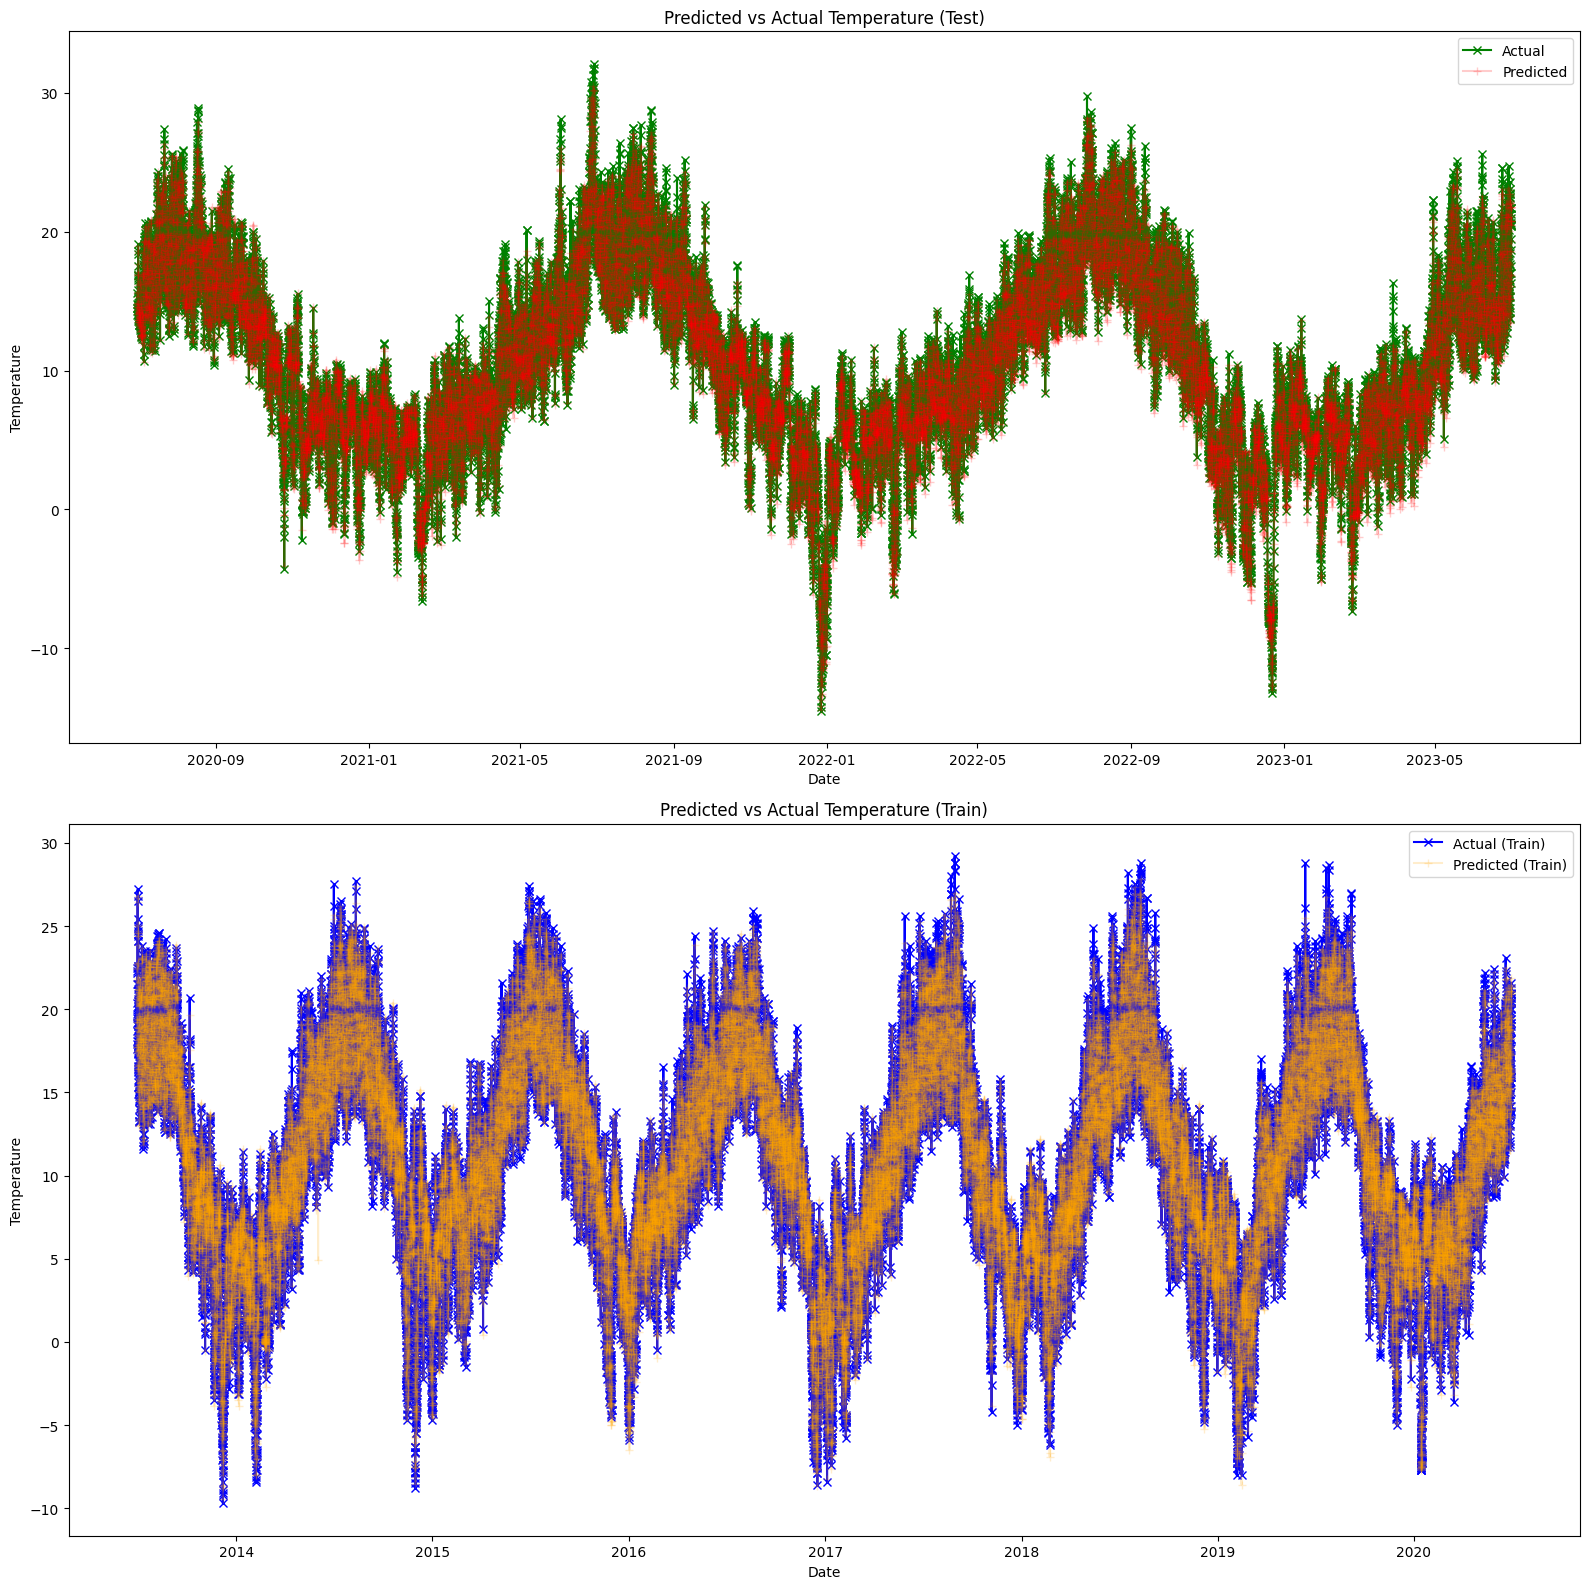

In [15]:
# Below I will plot the test predictions vs. actuals and then the train predictions vs. actuals.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))

# First subplot: Test Data
axes[0].plot(test_data['ds'], y_true, label='Actual', marker='x', color='g')
axes[0].plot(test_data['ds'], y_pred, label='Predicted', marker='+', color='r', alpha=.2)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Temperature')
axes[0].set_title('Predicted vs Actual Temperature (Test)')
axes[0].legend()

# Second subplot: Train Data
axes[1].plot(train_data['ds'], y_train_true, label='Actual (Train)', marker='x', color='b')
axes[1].plot(train_data['ds'], y_train_pred, label='Predicted (Train)', marker='+', color='orange', alpha=.2)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Temperature')
axes[1].set_title('Predicted vs Actual Temperature (Train)')
axes[1].legend()

plt.tight_layout()
plt.show()

## Model #5

In [16]:
# In this model we will drop the previous columns we discussed and dew point as well.
data_2 = df.drop(['max_air_temp_pst1hr', 'min_air_temp_pst1hr', 'pressure_sea', 'wind_dir', 'dew_point'], axis=1)

In [17]:
# In this new data we also need to rename the columns for the prophet model as before.
data_for_prophet_2 = data_2.rename(columns={"date_time_local": "ds", "temperature": "y"})

In [18]:
# The data will again be split before and after June 30, 2020 using the "ds" column.
train_data_2 = data_for_prophet_2[data_for_prophet_2['ds'] <= '2020-06-30']
test_data_2 = data_for_prophet_2[data_for_prophet_2['ds']>"2020-06-30"]

In [19]:
# This serves to double check the split and can be compared to the split on the previous model (notice this one has 11 variables instead of 12)
print(f" train_data Shape is: {train_data_2.shape}")
print(f" test_data Shape is: {test_data_2.shape}")

 train_data Shape is: (61345, 11)
 test_data Shape is: (26303, 11)


In [20]:
# This is the 5th model being considered for this project.
model_5 = Prophet()

In [21]:
# Same as before, each variable is looped through and a regressor is added to the model for each.
for column in ['pressure_station', 'wind_speed', 'wind_gust', 'relative_humidity', 'windchill', 'humidex', 'visibility', 'health_index', 'cloud_okta']:
    model_5.add_regressor(column)

# I can now fit the model with the training data, this time without the dew point.
model_5.fit(train_data_2)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp97p1nxzt/6roh9yjm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp97p1nxzt/hphwsjgh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1030', 'data', 'file=/tmp/tmp97p1nxzt/6roh9yjm.json', 'init=/tmp/tmp97p1nxzt/hphwsjgh.json', 'output', 'file=/tmp/tmp97p1nxzt/prophet_modelio6fvmk9/prophet_model-20230830212909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:29:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:30:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [22]:
# Like before, I am createing a dataframe for the predictions to include the whole time frame of the data set.
future_2 = pd.concat([train_data_2[['ds']], test_data_2[['ds']]], ignore_index=True)

# Adding the additional regressor values from both training and test data for the predictions.
for column in ['pressure_station', 'wind_speed', 'wind_gust', 'relative_humidity', 'windchill', 'humidex', 'visibility', 'health_index', 'cloud_okta']:
    future_2[column] = data_for_prophet_2[column]

# Predicting on the whole time frame using model #5.
forecast_2 = model_5.predict(future)

In [23]:
# Like before, I will split the predictions stored in "forecast" based on the dates.
forecast_train_2 = forecast_2.loc[forecast_2['ds'] <= "2020-06-30"]
forecast_test_2 = forecast_2.loc[forecast_2['ds'] > "2020-06-30"]

# I can then extract the predicted and actual values for the train data.
y_train_pred_2 = forecast_train_2['yhat']
y_train_true_2 = train_data_2['y']

# Computing the metrics for training data
train_mae_2 = mean_absolute_error(y_train_true_2, y_train_pred_2)
train_mse_2 = mean_squared_error(y_train_true_2, y_train_pred_2)
train_rmse_2 = np.sqrt(train_mse_2)
train_mape_2 = mean_absolute_percentage_error(y_train_true_2, y_train_pred_2)
train_r2_2 = r2_score(y_train_true_2, y_train_pred_2)

print(f'''Training Data:
Mean Absolute Error: {round(train_mae_2, 4)}
Mean Squared Error: {round(train_mse_2, 4)}
Root Mean Squared Error: {round(train_rmse_2, 4)}
Mean Absolute Percentage Error: {round(train_mape_2, 2)}%
R-squared: {train_r2_2}''')

# I can now extract the predicted and actual values for the test data.
y_pred_2 = forecast_test_2['yhat']
y_true_2 = test_data_2['y']

# Computing the metrics for the test data.
mae_2 = mean_absolute_error(y_true_2, y_pred_2)
mse_2 = mean_squared_error(y_true_2, y_pred_2)
rmse_2 = np.sqrt(mse_2)
mape_2 = mean_absolute_percentage_error(y_true_2, y_pred_2)
r2_2 = r2_score(y_true_2, y_pred_2)

print(f'''Test Data:
Mean Absolute Error: {round(mae_2, 4)}
Mean Squared Error: {round(mse_2, 4)}
Root Mean Squared Error: {round(rmse_2, 4)}
Mean Absolute Percentage Error: {round(mape_2, 2)}%
R-squared: {r2_2}''')

Training Data:
Mean Absolute Error: 1.5701
Mean Squared Error: 4.0271
Root Mean Squared Error: 2.0068
Mean Absolute Percentage Error: 48.32%
R-squared: 0.8976118513049186
Test Data:
Mean Absolute Error: 1.8077
Mean Squared Error: 5.2493
Root Mean Squared Error: 2.2911
Mean Absolute Percentage Error: 48.86%
R-squared: 0.8775585787291018


| Metric                         | Training Data         | Test Data            |
|--------------------------------|-----------------------|----------------------|
| Mean Absolute Error            | 1.5701                | 1.8077               |
| Mean Squared Error             | 4.0271                | 5.2493               |
| Root Mean Squared Error        | 2.0068                | 2.2911               |
| Mean Absolute Percentage Error | 48.32%                | 48.86%               |
| R-squared                      | 0.8976                | 0.8776               |


# Add analysis of the metrics here

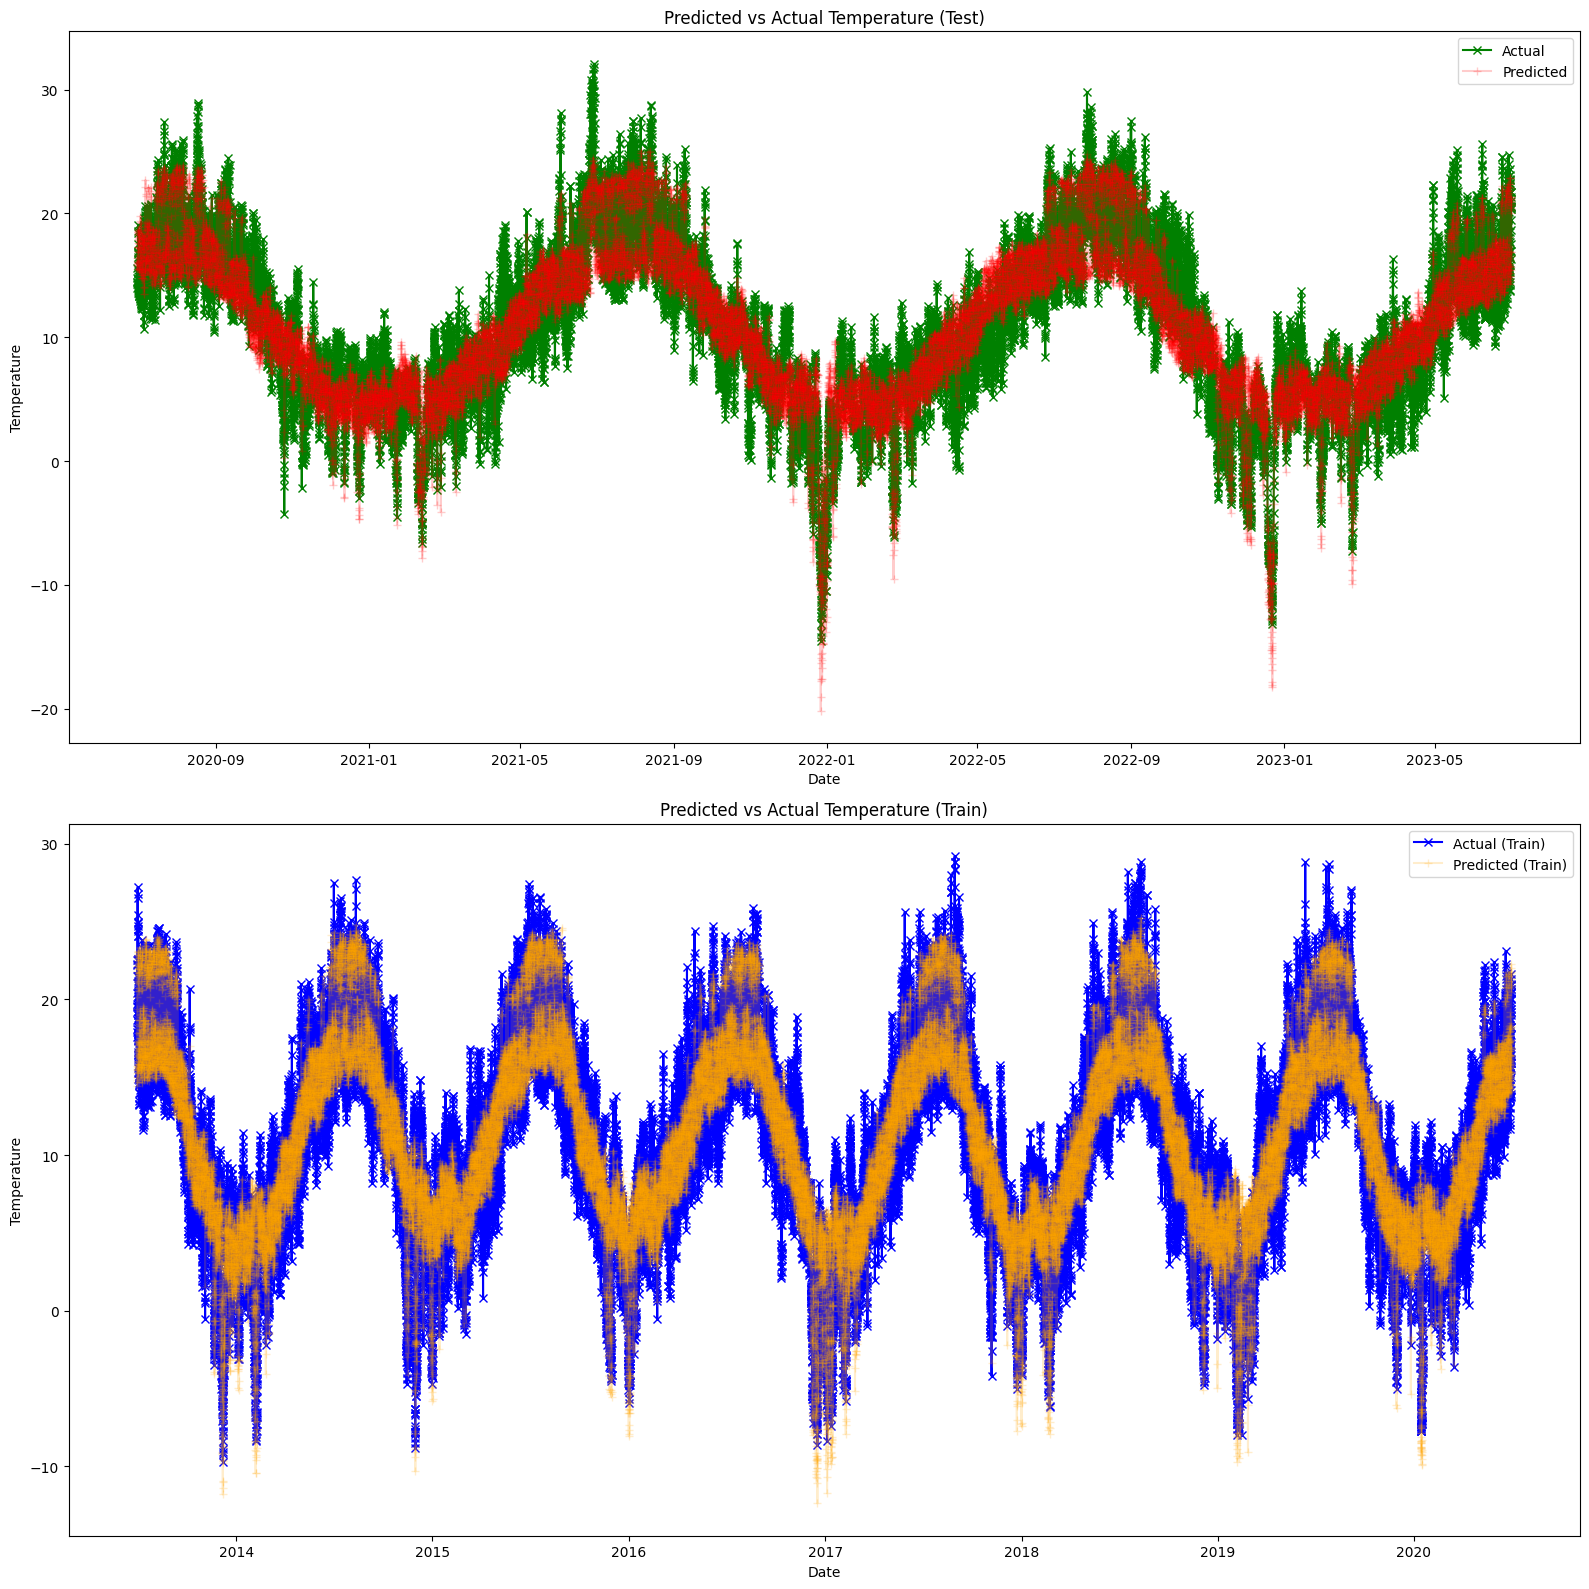

In [24]:
# I can now plot the test predictions vs. actuals as well as the train predictions vs. actuals for model #5.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))

# First subplot: Test Data
axes[0].plot(test_data_2['ds'], y_true_2, label='Actual', marker='x', color='g')
axes[0].plot(test_data_2['ds'], y_pred_2, label='Predicted', marker='+', color='r', alpha=.2)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Temperature')
axes[0].set_title('Predicted vs Actual Temperature (Test)')
axes[0].legend()

# Second subplot: Train Data
axes[1].plot(train_data_2['ds'], y_train_true_2, label='Actual (Train)', marker='x', color='b')
axes[1].plot(train_data_2['ds'], y_train_pred_2, label='Predicted (Train)', marker='+', color='orange', alpha=.2)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Temperature')
axes[1].set_title('Predicted vs Actual Temperature (Train)')
axes[1].legend()

plt.tight_layout()
plt.show()